In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, glob
import soundfile as sf # read audio
import sofa # read SOFA HRTFs
import librosa # resample function
from scipy import signal # fst convolution function
from IPython.display import Audio # Audio listening in notebook
import os

In [4]:
os.getcwd()

'C:\\Users\\adft0'

In [3]:
os.chdir('../')

In [5]:
source_dir = '_UntitledGrasshopperRadishProject/Music Sample/*.mp3'
hrtf_dir_MIT = 'Desktop/HRTFsets/MIT/diffuse/elev0/*.wav'
hrtf_dir_LISTEN = 'Desktop/HRTFsets/LISTEN/IRC_1025/COMPENSATED/WAV/IRC_1025_C/*.wav'
hrtf_dir_SOFA = 'Desktop/HRTFsets/SOFA Far-Field/*.sofa'

_SOURCES = glob.glob(source_dir)
_MIT = glob.glob(hrtf_dir_MIT)
_LISTEN = glob.glob(hrtf_dir_LISTEN)
_SOFA = glob.glob(hrtf_dir_SOFA)

In [6]:
print('List of Source files:')
for s in range(len(_SOURCES)):
    print('\033[1m' + str(s) +'. ' + '\033[0m' + _SOURCES[s][15:-8])

List of Source files:
0. opperRadishProject/Music Sample\Floor Nail Hamm
1. opperRadishProject/Music Sample\KICK 


In [7]:
_MIT.sort()
_MIT

['Desktop/HRTFsets/MIT/diffuse/elev0\\H0e000a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e005a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e010a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e015a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e020a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e025a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e030a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e035a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e040a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e045a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e050a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e055a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e060a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e065a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e070a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e075a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e080a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e085a.wav',
 'Desktop/HRTFsets/MIT/diffuse/elev0\\H0e090a.wav',
 'Desktop/HR

In [8]:
az_index = 7
print('Using HRTF: ' + _MIT[az_index])
[HRIR,fs_H] = sf.read(_MIT[az_index])
print('Sample rate = ' + str(fs_H))
print('Data dimensions: ',HRIR.shape) # 128개의 data / 2 channel

Using HRTF: Desktop/HRTFsets/MIT/diffuse/elev0\H0e035a.wav
Sample rate = 44100
Data dimensions:  (128, 2)


In [9]:
Audio(HRIR.transpose(),rate=fs_H)
# 이 함수는 channel을 row로, sample을 column으로 요구한다. 따라서 Transpose해준다.

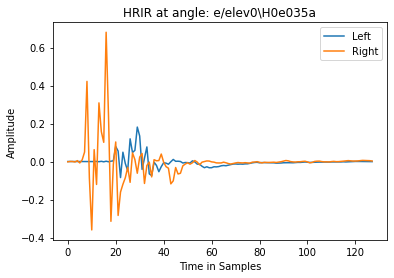

In [10]:
# Visualization
plt.plot(HRIR[:,0]) # Left channel (위에서 128,2 인 데이터이므로 :,0은 첫번째 채널)
plt.plot(HRIR[:,1]) # Right channel
plt.xlabel('Time in Samples')
plt.ylabel('Amplitude')
plt.title('HRIR at angle: ' + _MIT[az_index][27:-4])
plt.legend(['Left','Right']);

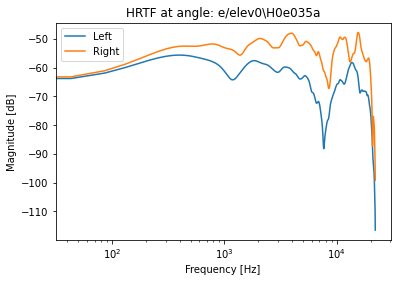

In [11]:
# Frequency domain Visualization
nfft = len(HRIR)*8
HRTF = np.fft.fft(HRIR, n=nfft, axis=0)
HRTF_mag = (2/nfft)*np.abs(HRTF[0:int(len(HRTF)/2)+1,:])
HRTF_mag_dB = 20*np.log10(HRTF_mag)

f_axis = np.linspace(0, fs_H/2, len(HRTF_mag_dB))
plt.semilogx(f_axis, HRTF_mag_dB)
plt.title('HRTF at angle: ' + _MIT[az_index][27:-4])
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.legend(['Left','Right'])

In [12]:
source_idx = 0
print('Source is: ' + _SOURCES[source_idx][15:-8])
[sig, fs_s] = sf.read(_SOURCES[source_idx])
print('Sample rate: ', fs_s)
print('Data dimensions: ', sig.shape)

Source is: opperRadishProject/Music Sample\Floor Nail Hamm
Sample rate:  44100
Data dimensions:  (599040, 2)


In [13]:
if sig.shape[1]>1:
    sig_mono = np.mean(sig,axis=1)
else:
    sig_mono = sig

print('New data dimensions: ',sig_mono.shape)

Audio(sig_mono,rate=fs_s)

New data dimensions:  (599040,)


In [14]:
def fs_resample(s1, f1, s2, f2):
    if f1 != f2:
        if f2 < f1:
            s2 = librosa.core.resample(s2.transpose(),f2,f1)
            s2 = s2.transpose()
        else:
            s1 = librosa.core.resample(s1.transpose(),f1,f2)
            s1 = s1.transpose()
    fmax = max([f1,f2])
    f1 = fmax
    f2 = fmax
    print('Resampled at: ', fmax, 'Hz')
    return s1, f1, s2, f2

In [15]:
[sig_mono, fs_s, HRIR, fs_H] = fs_resample(sig_mono, fs_s, HRIR, fs_H)
print('sig dimensions: ', sig_mono.shape)
print('hrir dimensions: ', HRIR.shape)

Resampled at:  44100 Hz
sig dimensions:  (599040,)
hrir dimensions:  (128, 2)


In [16]:
s_L = np.convolve(sig_mono, HRIR[:,0])
s_R = np.convolve(sig_mono, HRIR[:,1])

Bin_Mix = np.vstack([s_L,s_R]).transpose()
print('Data Dimensions: ', Bin_Mix.shape)

Data Dimensions:  (599167, 2)


In [17]:
Audio(Bin_Mix.transpose(),rate=fs_s)